# Force Directed Scatter Plot

When we have a scatterplot with overlapping points, how can we best arrange the points that is most faithful to the data, but avoids overlap?

In [102]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [103]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def intersection_area(x1, y1, x2, y2, r1, r2):
    """Return the area of intersection of two circles.
    The circles have radii R and r, and their centres are separated by d.
    """

    d = distance(x1, y1, x2, y2)
    if d <= abs(r1 - r2):   # complete overlap
        return np.pi * min(r1, r2)**2
    if d >= r1 + r2:        # no overlap at all
        return 0

    r1sq, r2sq, dsq = r1**2, r2**2, d**2
    alpha = np.arccos((dsq + r1sq - r2sq) / (2*d*r1))
    beta = np.arccos((dsq + r2sq - r1sq) / (2*d*r2))
    return (
        r1sq * alpha + r2sq * beta -
        0.5 * (r1sq * np.sin(2 * alpha) + r2sq * np.sin(2 * beta))
    )

In [147]:
def force_scatter_layout(x, y, r, t=0.5, iterations=1000, tol=0.001):
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    
    area = (xmax - xmin) * (ymax - ymin)
    
    n_points = len(x)
    k = np.sqrt(area/n_points)
    
    all_pairs = list(itertools.combinations(range(n_points), 2))
    x_current, y_current = x.copy(), y.copy()
    
    dt = t/iterations

    for i in range(iterations):
        
        dx = np.zeros(n_points)
        dy = np.zeros(n_points)
        
        repulsive_forces = np.zeros(len(all_pairs))
        attractive_forces = np.zeros(n_points)
        
        for i, pair in enumerate(all_pairs):
            pt1 = pair[0]
            pt2 = pair[1]
            intersection = intersection_area(
                x_current[pt1],
                y_current[pt1],
                x_current[pt2],
                y_current[pt2],
                radii[pt1],
                radii[pt2]
            )
            repulsive_forces[i] = intersection
            
            if intersection > 0:
                # repulse! we use the attraction force though
                f = f_a(intersection, k)*10
                dx[pt1] += (x_current[pt1] - x_current[pt2])*f/2
                dy[pt1] += (y_current[pt1] - y_current[pt2])*f/2

                dx[pt2] += (x_current[pt1] - x_current[pt2])*(-f/2)
                dy[pt2] += (y_current[pt1] - y_current[pt2])*(-f/2)

        # attractive force
        # TODO: make attractice force proportionate to relative radius ... bigger guys don't move :-)
        for i in range(n_points):
            d = distance(x[i], y[i], x_current[i], y_current[i])
            f = f_a(d, k)   #*radii[i]/max_radii
            attractive_forces[i] = f
            dx[i] += (x_current[i] - x[i]) * -f
            dy[i] += (y_current[i] - y[i]) * -f

        for i in range(n_points):
            max_x, max_y = 0, 0
            disp = np.sqrt(dx[i]*dx[i] + dy[i]*dy[i])
            if disp != 0:
                d = min(disp, t)/disp
                x_current[i] = x_current[i] + dx[i]*d
                y_current[i] = y_current[i] + dy[i]*d

                if abs(dx[i]*d) > max_x:
                    max_x = abs(dx[i]*d)
                if abs(dy[i]*d) > max_y:
                    max_y = abs(dy[i]*d)
        
        if max_x < tol and max_y < tol:
            print(f'tol reached! ran {i+1} iters!')
            break

        t -= dt

    return x_current, y_current

In [155]:
x = [21, 20, 22, 21, 40, 23, 0, 1]
y = [7, 6, 4, 5, 20, 8, 0, 1]
radii = np.array([2.5, 2, 1.5, 1, 1, 4, 1, 2])

x = np.random.randn(5)
y = np.random.randn(5)
radii = np.random.uniform(low=1, high=3.3, size=(5,))


In [156]:
nx, ny = force_scatter_layout(x, y, radii)

tol reached! ran 5 iters!


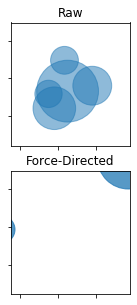

In [157]:
# https://stackoverflow.com/questions/48172928/scale-matplotlib-pyplot-axes-scatter-markersize-by-x-scale/48174228#48174228

xmin = min(x)
xmax = max(x)

ymin = min(y)
ymax = max(y)

fig, ax = plt.subplots(2,1, dpi=72, figsize=(10, 5))
for i, axes in enumerate(ax):
    axes.set_xlim(xmin-1, xmax+1)
    axes.set_ylim(ymin-1, ymax+1)
    axes.set_aspect(1)
    axes.xaxis.set_ticklabels([])
    axes.yaxis.set_ticklabels([])
    
fig.canvas.draw()
s = ((ax[0].get_window_extent().width/(10) * 72./fig.dpi) ** 2)
ax[0].scatter(x, y, s = s*radii**2*np.pi, alpha=0.5)
ax[1].scatter(nx, ny, s = s*radii**2*np.pi, alpha=0.75)
ax[0].set_title('Raw')
ax[1].set_title('Force-Directed')


plt.show()

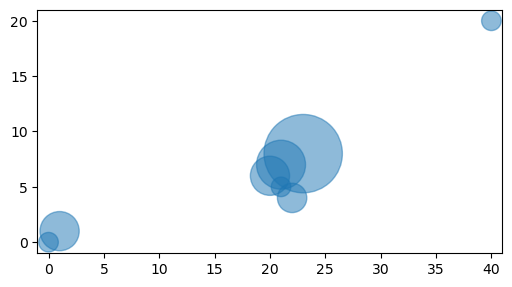

In [98]:
# https://stackoverflow.com/questions/48172928/scale-matplotlib-pyplot-axes-scatter-markersize-by-x-scale/48174228#48174228

xmin = min(x)
xmax = max(x)

ymin = min(y)
ymax = max(y)

fig, ax = plt.subplots(dpi=100)
ax.set_xlim(xmin-1, xmax+1)
ax.set_ylim(ymin-1, ymax+1)

ax.set_aspect(1)
fig.canvas.draw()
s = ((ax.get_window_extent().width/(41.) * 72./fig.dpi) ** 2)
ax.scatter(x, y, s = 0.95*s*radii**2*np.pi, alpha=0.5)

plt.show()

In [100]:
area = (xmax-xmin)*(ymax-ymin)
n_points = len(x)
k = np.sqrt(area/n_points)

# attractive force
def f_a(d,k):
    return d*d/k

# repulsive force
def f_r(d,k):
    return k*k/d

all_pairs = list(itertools.combinations(range(n_points), 2))
x_current = x.copy()
y_current = y.copy()

In [101]:
k

10.0

In [31]:
all_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 6),
 (5, 7),
 (6, 7)]

In [32]:
%%time

t = 1
iterations = 100
dt = t/iterations

for i in range(iterations):
    overlaps = 0
    dx = np.zeros(n_points)
    dy = np.zeros(n_points)
    repulsive_forces = np.zeros(len(all_pairs))
    attractive_forces = np.zeros(n_points)
    for i, pair in enumerate(all_pairs):
        pt1 = pair[0]
        pt2 = pair[1]
        intersection = intersection_area(x_current[pt1], y_current[pt1], x_current[pt2], y_current[pt2], radii[pt1], radii[pt2])
        repulsive_forces[i] = intersection
        if intersection > 0:
            overlaps += 1
            # repulse! we use the attraction force though
            f = f_a(intersection, k)*10
            print(f)
            dx[pt1] += (x_current[pt1] - x_current[pt2])*f/2
            dy[pt1] += (y_current[pt1] - y_current[pt2])*f/2
        
            dx[pt2] += (x_current[pt1] - x_current[pt2])*(-f/2)
            dy[pt2] += (y_current[pt1] - y_current[pt2])*(-f/2)
    if overlaps == 0:
        print(f'no overlaps! ran {i+1} iters!')
        break

    # attractive force
    # TODO: make attractice force proportionate to relative radius ... bigger guys don't move :-)
    for i in range(n_points):
        d = distance(x[i], y[i], x_current[i], y_current[i])
        f = f_a(d, k)   #*radii[i]/max_radii
        attractive_forces[i] = f
        dx[i] += (x_current[i] - x[i]) * -f
        dy[i] += (y_current[i] - y[i]) * -f
    
    print(repulsive_forces)
    print(attractive_forces)
    print(dx)
    print(dy)

    for i in range(n_points):
        disp = np.sqrt(dx[i]*dx[i] + dy[i]*dy[i])
        print(f'disp: {disp}')
        if disp != 0:
            d = min(disp, t)/disp
            print(f'd: {d}')
            x_current[i] = x_current[i] + dx[i]*d
            y_current[i] = y_current[i] + dy[i]*d
    
    t -= dt

88.77061917818716
1.796797967276083
5.879602138309103
293.150549659471
0.86458210703874
6.533481654846323
51.36907099617092
2.2791062071900425
8.365480183744948
5.147233816548084
6.533481654846323
[ 9.42181613  1.34044693  2.42478909  0.         17.12163981  0.
  0.          0.92982907  2.55606762  0.          7.16722199  0.
  0.          1.50967089  0.          2.89231398  0.          0.
  0.          2.2687516   0.          0.          0.          0.
  0.          0.          0.          2.55606762]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-249.66363905 -125.57023902   -1.2802059    -3.02004609    0.
  379.53413006   -3.26674083    3.26674083]
[-93.61516615 -91.62305765 -21.43029253 -15.72764059   0.
 222.39615692  -3.26674083   3.26674083]
disp: 266.63782927268863
d: 0.003750405569711217
disp: 155.44346116923896
d: 0.006433207241257004
disp: 21.46849703683013
d: 0.04657987926609194
disp: 16.014972895222915
d: 0.0624415668101623
disp: 0.0
disp: 439.89340355820775
d: 0.0022732780076063987
disp: 4.6

0.0466772054745987
0.7799511291490648
0.33409442686000257
4.199558819047555e-06
0.02308185433607002
[0.25653432 0.         0.         0.         0.14842756 0.
 0.         0.21604908 0.88314842 0.         0.         0.
 0.         0.57800902 0.         0.         0.         0.
 0.         0.00204928 0.         0.         0.         0.
 0.         0.         0.         0.15192713]
[0.6235108  0.66841325 0.13130372 0.03984602 0.         0.3578966
 0.04691143 0.04691143]
[ 1.41440014e+00 -5.35609624e-01  1.83429759e-01  5.06223421e-01
  0.00000000e+00 -5.91980113e-01  2.77555756e-17 -2.77555756e-17]
[-2.18748406e-01  1.09891133e+00 -1.43909712e-01  7.30998982e-01
  0.00000000e+00 -1.36369353e-01  2.77555756e-17 -2.77555756e-17]
disp: 1.4312157833522139
d: 0.17467666504798166
disp: 1.2224908094921008
d: 0.2045005148986478
disp: 0.23314476529161277
d: 1.0
disp: 0.8891690859377949
d: 0.28116137184001133
disp: 0.0
disp: 0.6074842012248084
d: 0.41153333616898985
disp: 3.925231146709438e-17
d: 1

In [33]:
overlaps

7

In [36]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7eb15f77b8>,
      dtype=object)